## EXERCISE 4

We want to study the performances of an RBM, and, by looking at its learned weights and biases, better understand the correlations in the data (from file x_RBM_2024_exercise.dat, N=104 configurations with L=10 bits). Use an RBM with M=3 hidden units.

| Name | Surname | ID Number |
|------|---------|---------------------|
| Lucrezia | Rossi | 2122164 |
| Lorenzo | Calandra Buonaura | 2107761 |
| Andrea | Turci | 2106724 |

In [1]:
import numpy as np
from numpy import exp, sqrt, abs
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 13
import itertools as it

from IPython.display import display_html 
import pandas as pd

In [2]:
dname = "DATA"; fname = dname + '/x_RBM_2024_exercise.dat'

v = np.loadtxt(fname, delimiter = " ", dtype = int)
N = len(v)
L = len(v[1])
# store in v0, because later we will shuffle v
v0 = np.copy(v)
print(f'each of N={N} data has L={L} digits')
#SPINS = True
SPINS = False

if SPINS:
    # sigmoid takes into account energy difference =2
    GAP=2
    # convert 0,1 -> -1,1
    v = 2*v - 1
    vmin=-1
else:
    GAP=1
    vmin=0

print(f'each of N={N} data has L={L} digits')

for i in range(min(12,N)):
    if SPINS: print(v0[i],"\n->",v[i])
    else: print(v[i])
print('...')

each of N=10000 data has L=10 digits
each of N=10000 data has L=10 digits
[0 0 1 1 0 0 0 0 1 1]
[0 0 0 1 0 0 0 1 0 0]
[1 0 0 0 1 0 1 0 0 0]
[0 1 1 1 0 1 0 1 0 0]
[1 1 1 0 1 1 1 1 0 0]
[0 1 0 0 1 1 1 0 0 0]
[1 0 1 0 0 0 1 1 1 1]
[1 0 1 1 0 1 1 0 0 0]
[1 0 1 0 0 0 0 1 1 1]
[1 1 0 0 1 1 0 0 0 0]
[0 1 0 1 0 0 0 0 1 1]
[1 1 0 1 1 1 1 1 0 0]
...


In [3]:
def is_one(cell_value):
    color0 = 'background-color: gray; color: white'
    color1 = 'background-color: white;'
    if type(cell_value) in [float, int]:
        if cell_value == 1:
            return color1
    return color0

N1=12
df0 = pd.DataFrame(v[:N1])
df0s = df0.style.set_table_attributes("style='display:inline'")
df0s.map(is_one)
sty = [dict(selector="caption",props=[("font-size", "150%")])]
df0s.set_caption('Original').set_table_styles(sty)

display_html(df0s._repr_html_(), raw=True)

,0,1,2,3,4,5,6,7,8,9
0,0,0,1,1,0,0,0,0,1,1
1,0,0,0,1,0,0,0,1,0,0
2,1,0,0,0,1,0,1,0,0,0
3,0,1,1,1,0,1,0,1,0,0
4,1,1,1,0,1,1,1,1,0,0
5,0,1,0,0,1,1,1,0,0,0
6,1,0,1,0,0,0,1,1,1,1
7,1,0,1,1,0,1,1,0,0,0
8,1,0,1,0,0,0,0,1,1,1
9,1,1,0,0,1,1,0,0,0,0


In [4]:
class RBM:
    def __init__(self, L, M, GAP=1.0):
        self.L = L  # Number of visible units
        self.M = M  # Number of hidden units
        self.GAP = GAP  # Parameter for activation function
        self.sigma = np.sqrt(4. / float(L + M))  # Range of initial weight
        self.w = None  # Weight matrix
        self.a = None  # Visible bias
        self.b = None  # Hidden bias
        

    def _initialize_weights(self):
        np.random.seed(12345)
        self.w = self.sigma * np.random.randn(self.L, self.M)
        self.a = self.sigma * np.random.randn(self.L)
        self.b = np.zeros(self.M)
        
        self.w0 = np.copy(self.w)
        self.a0 = np.copy(self.a)
        self.b0 = np.copy(self.b)
        
        #print("w =", self.w)
        #print("a =", self.a)
        #print("b =", self.b)

    def _energy(self, v, h):
        return -np.dot(v, self.a) - np.dot(h, self.b) - np.sum(np.dot(v, self.w) * h)
    
    def _log_likelihood(self, data):
        num_samples = data.shape[0]
        avg_energy_data = 0
        
        for v in data:
            possible_configs_h = list(it.product([0, 1], repeat=self.M))
            energy_sum = np.sum([self._energy(v, h) * np.exp(-self._energy(v, h)) for h in possible_configs_h])
            partition_func = np.sum([np.exp(-self._energy(v, h)) for h in possible_configs_h])
            
            avg_energy_data += energy_sum / partition_func
        
        avg_energy_data /= num_samples  
        
        partition_func = 0
        for v in it.product([0, 1], repeat=self.L):
            for h in it.product([0, 1], repeat=self.M):
                partition_func += np.exp(-self._energy(v, h))
        
        log_likelihood = -avg_energy_data - np.log(partition_func)
        
        return log_likelihood     

    def _activate(self, v_in, wei, bias, DeltaE, info=False):
        
        act = np.dot(v_in, wei) + bias
        n = np.shape(act)
        prob = 1. / (1. + exp(-DeltaE*act))
        v_out = np.full(n, vmin, dtype=int) # a list on -1's or 0's
        v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
        if info:
            print('input=', v_in)
            print('act=',act)
            print('prob=',prob)
            print('output=',v_out)
        return v_out

    def compute_cd_steps(self, cd_steps, h_i):
        hf=h_i  #set for the sake of the loop
        for i in range(cd_steps):
            # negative CD phase: generating fantasy vf
            vf = self._activate(hf,self.w.T,self.a,self.GAP)
            # one more positive CD phase: generating fantasy h from fantasy vf 
            hf = self._activate(vf,self.w,self.b,self.GAP)
        return vf,hf
    
    def train(self, v_in, l_rate=1.0, minibatch_size=500, n_epochs=100, n_steps=5):
        N = len(v_in)
        np.random.seed(12345)
        np.random.shuffle(v_in)
        self.m = 0
        for epoch in range(n_epochs):
            l_rate_epoch = l_rate / minibatch_size
            for k in range(N):
                if self.m == 0:
                    self._initialize_minibatch()

                h = self._activate(v_in[k], self.w, self.b, GAP)
                
                vf, hf = self.compute_cd_steps(n_steps, h)

                self.v_data += v_in[k]
                self.v_model += vf
                self.h_data += h
                self.h_model += hf #correzione

                self.vh_data += np.outer(v_in[k].T, h)
                self.vh_model += np.outer(vf.T, hf)   #correzione

                self.m += 1

                if self.m == minibatch_size:
                    dw = l_rate_epoch * (self.vh_data - self.vh_model)
                    da = l_rate_epoch * (self.v_data - self.v_model)
                    db = l_rate_epoch * (self.h_data - self.h_model)

                    #if epoch<=1 and k<=mini:
                        #print('----------- epoch =',epoch,'  k=',k,'  m=',m)
                        #print('dw =',dw)
                        #print('da =',da)
                        #print('db =',db)
                    
                    self.w += dw
                    self.a += da
                    self.b += db
                    
                    self.m = 0 #correzione
                    
            np.random.shuffle(v)
            l_rate = l_rate / (0.01 * l_rate + 1)


    def _initialize_minibatch(self):
        self.v_data = np.zeros(self.L)
        self.v_model = np.zeros(self.L)
        self.h_data = np.zeros(self.M)
        self.h_model = np.zeros(self.M)
        self.vh_data = np.zeros((self.L, self.M))
        self.vh_model = np.zeros((self.L, self.M))

    def plot_graph(self, epoch=0):
        fig, ax = plt.subplots(1, 1, figsize=(7, 3.3))
        ax.tick_params(left=False, bottom=False)
        ax.xaxis.set_major_formatter(plt.NullFormatter())
        ax.yaxis.set_major_formatter(plt.NullFormatter())

        x1 = [0] * self.L
        y1 = list(range(self.L))
        for i in range(self.L):
            y1[i] = 1 * (y1[i] / (self.L - 1.) - 0.5)
            
        x2 = [1] * self.L
        y2 = list(range(self.L))
        for i in range(self.L):
            y2[i] = 0.7 * (y2[i] / (self.L - 1.) - 0.5)
            
        A = 1. / max(self.w.max(), -self.w.min())
        for i in range(self.L):
            for j in range(self.M):
                ex, ey, col = (y1[i], y2[j]), (x1[i], x2[j]), self._my_color(self.w[i][j])
                ax.plot(ex, ey, col, zorder=1, alpha=A * abs(self.w[i][j]))

        A = 300.
        for i in range(self.L):
            ax.scatter(y1[i], x1[i], s=A * abs(self.a[i]), zorder=2, c=self._my_color(self.a[i]))

        for j in range(self.M):
            ax.scatter(y2[j], x2[j], s=min(300, A * abs(self.b[j])), zorder=2, c=self._my_color(self.b[j]),
                       marker="s")
        ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
        ax.text(-0.51, 0.85, "hidden\nlayer")
        plt.show()

    @staticmethod
    def _my_color(val):
        if val > 0:
            return 'red'
        elif val < 0:
            return 'blue'
        else:
            return 'black'

### 1\.
Increase the number of contrastive divergence steps from n=1 to n=5.

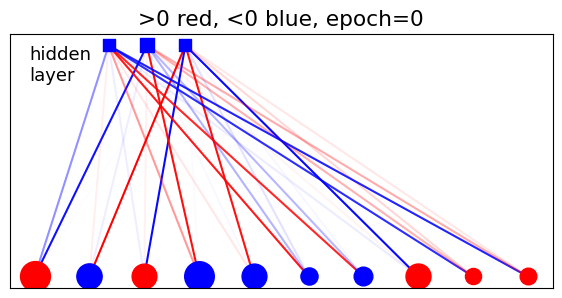

In [5]:
# Create RBM instance
rbm = RBM(L, M=3, GAP=1)

# Plot graph
rbm._initialize_weights()  # Initialize weights
rbm.train(v, n_steps=5)

# Plot graph after training
rbm.plot_graph()

### 2\.
Compute the log-likelihood L  during the training, at every epoch, or every minibatch update if it 
reaches a maximum already in the first epoch. Use “t” as an index of this “time”, indicating the unit 
in the figures.

In [6]:
log_likelihoods = []
for epoch in range(100):  
    rbm.train(v, n_epochs=1, n_steps=5)  
    ll = rbm._log_likelihood(v)  
    log_likelihoods.append(ll)

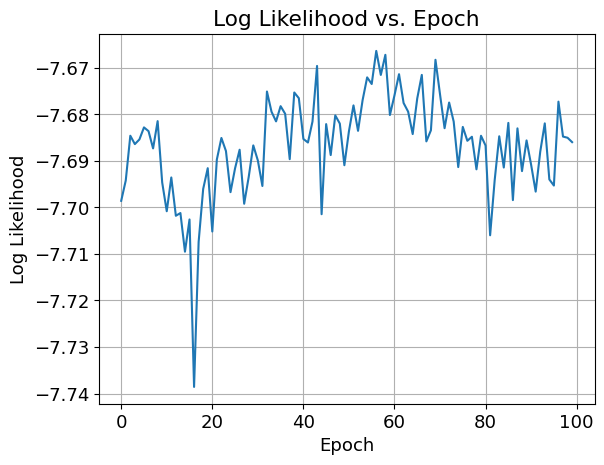

In [7]:
# Plot log likelihood vs. epoch
plt.plot(range(len(log_likelihoods)), log_likelihoods)
plt.xlabel('Epoch')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood vs. Epoch')
plt.grid(True)
plt.show()

5.
Try RBMs with different numbers of hidden units: M=1, 2, 3 (done above), 4, 5, and 6.

Training RBM with 1 hidden units...


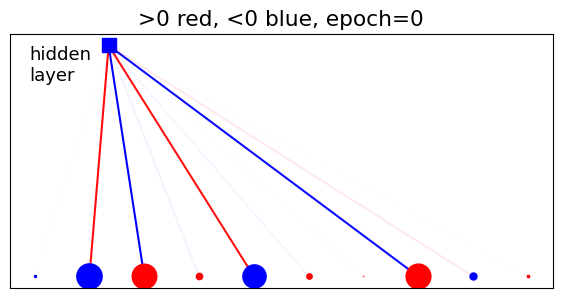

Training RBM with 2 hidden units...


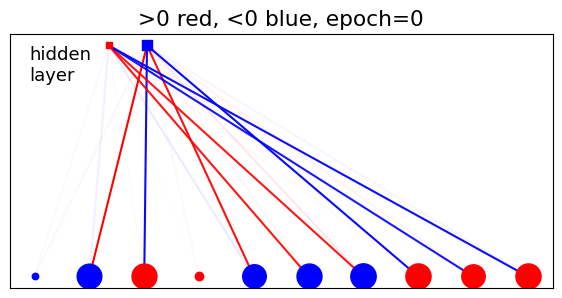

Training RBM with 4 hidden units...


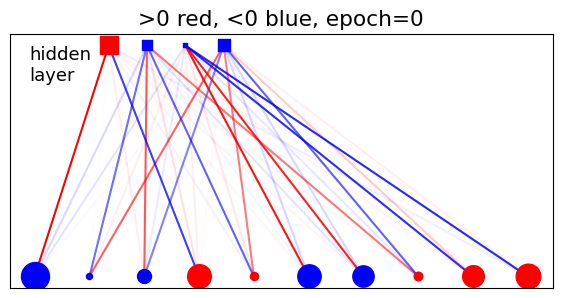

Training RBM with 5 hidden units...


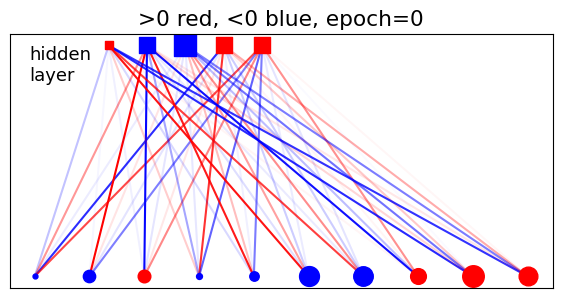

Training RBM with 6 hidden units...


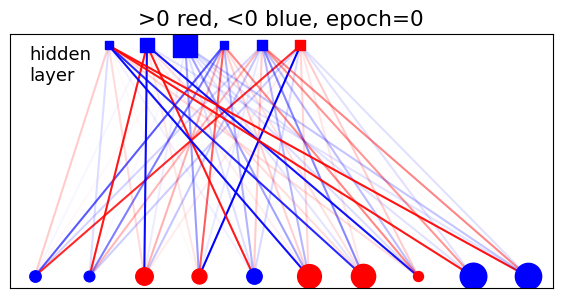

In [8]:
hidden_units = [ 1,2, 4, 5, 6]

for M in hidden_units:
    print(f"Training RBM with {M} hidden units...")
    rbm = RBM(L=L, M=M, GAP=GAP)  # Create RBM instance
    rbm._initialize_weights()  # Initialize weights
    rbm.train(v)  # Train RBM using loaded data
    rbm.plot_graph()  # Plot the learned features

### Answer 5:

### 3\.
for M=3, plot L  as a function of “t”, comparing the two contrastive divergence cases (n=1 and 
n=5). Then, for n=1, plot L  as a function of “t”, comparing the two cases with different M.

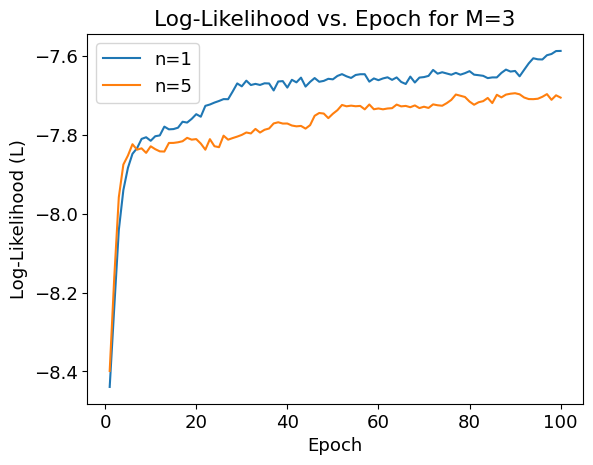

In [9]:
# Initialize RBM with M=3
rbm_n1 = RBM(L=10, M=3, GAP=1.0)
rbm_n5 = RBM(L=10, M=3, GAP=1.0)
rbm_n1._initialize_weights()
rbm_n5._initialize_weights()

# Train RBM with n=1
log_likelihoods_n1 = []
for epoch in range(100):  
    rbm_n1.train(v, n_epochs=1, n_steps=1)  
    ll_n1 = rbm_n1._log_likelihood(v)  
    log_likelihoods_n1.append(ll_n1)

# Train RBM with n=5
log_likelihoods_n5 = []
for epoch in range(100):  
    rbm_n5.train(v, n_epochs=1, n_steps=5)  
    ll_n5 = rbm_n5._log_likelihood(v)  
    log_likelihoods_n5.append(ll_n5)

# Plot log-likelihood as a function of epoch number
epochs = range(1, len(log_likelihoods_n1) + 1) 
plt.plot(epochs, log_likelihoods_n1, label='n=1')
plt.plot(epochs, log_likelihoods_n5, label='n=5')
plt.xlabel('Epoch')
plt.ylabel('Log-Likelihood (L)')
plt.title('Log-Likelihood vs. Epoch for M=3')
plt.legend()
plt.show()

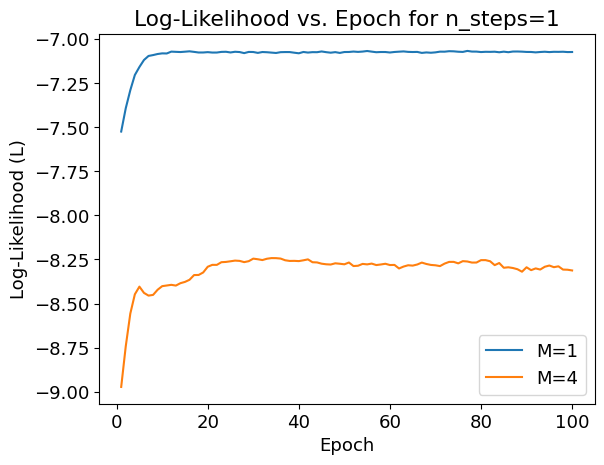

In [10]:
# Initialize RBM with different M
rbm_m1 = RBM(L=10, M=1, GAP=1.0)
rbm_m4 = RBM(L=10, M=4, GAP=1.0)
rbm_m1._initialize_weights()
rbm_m4._initialize_weights()

# Train RBM with M=1
log_likelihoods_m1 = []
for epoch in range(100):  
    rbm_m1.train(v, n_epochs=1, n_steps=1)  
    ll_m1 = rbm_m1._log_likelihood(v)  
    log_likelihoods_m1.append(ll_m1)

# Train RBM with M=4
log_likelihoods_m4 = []
for epoch in range(100):  
    rbm_m4.train(v, n_epochs=1, n_steps=1)  
    ll_m4 = rbm_m4._log_likelihood(v)  
    log_likelihoods_m4.append(ll_m4)

# Plot log-likelihood as a function of epoch number
epochs = range(1, len(log_likelihoods_n1) + 1) 
plt.plot(epochs, log_likelihoods_m1, label='M=1')
plt.plot(epochs, log_likelihoods_m4, label='M=4')
plt.xlabel('Epoch')
plt.ylabel('Log-Likelihood (L)')
plt.title('Log-Likelihood vs. Epoch for n_steps=1')
plt.legend()
plt.show()

### 4\.
From the weights learned by the RBM, guess the structure of the data

### Answer 4:
Several significant observations emerge regarding the data structure and the effectiveness of RBM in learning them:

* Structure of connections between hidden layers and visible data: For n_steps=5, it is observed that for M=1 and M=2, the hidden layers have very weak or almost transparent connections with the visible data, suggesting a low correlation. However, for M=3, a stronger connection with a single hidden layer is observed, indicating increased interaction between the data and the hidden layers. As M increases beyond 3, the connections become more chaotic and less distinct.

* Trend of log-likelihood in relation to n_steps: It is observed that the log-likelihood for n_steps=1 is slightly higher than n_steps=5 for M=3. Both log-likelihoods show an increase with increasing epochs, indicating convergence of the model towards an optimal data representation. However, the difference in log-likelihood suggests that n_steps=1 might converge more rapidly or may be more suitable for this particular dataset.

* Effect of the number of hidden layers on log-likelihood: For n_steps=1, it is observed that the log-likelihood for M=1 increases rapidly initially and remains relatively constant, suggesting that a single hidden layer is sufficient to capture the relationships in the data. However, for M=4, the log-likelihood starts from a lower value and shows a gradual increase, indicating that a greater number of hidden layers may be necessary to model the complexity of the data more accurately.

In summary, the data indicates that the data structure may be better represented by a model with a moderate number of hidden layers (M=3) and with a low number of contrastive divergence steps (n_steps=1), which shows rapid improvement in log-likelihood and greater stability over time. These observations suggest that the RBM model is effectively capturing relationships in the data and converging towards an optimal representation.